In [ ]:
# ====== إعداد البيئة ======
!pip -q install xgboost kaggle seaborn

import os, sys, json, zipfile, io, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

from xgboost import XGBClassifier

print("Ready ✅")


Ready ✅


In [ ]:
# ====== تهيئة Kaggle API (اختياري لكنه مُفضّل) ======
from pathlib import Path

use_kaggle = False
kaggle_json_path = Path("/content/kaggle.json")

if kaggle_json_path.exists():
    use_kaggle = True
    !mkdir -p ~/.kaggle
    !cp /content/kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API is configured ✅")
else:
    print("⚠️ لم يتم العثور على kaggle.json. سنحاول البديل المحلي.")

# ====== تنزيل مجموعة البيانات من Kaggle إذا أمكن ======
dataset_dir = Path("/content/data")
dataset_dir.mkdir(parents=True, exist_ok=True)
csv_path = dataset_dir / "smoke_detection.csv"  # اسم موحد سنستخدمه لاحقًا

if use_kaggle:
    # رابط الداتاسيت: deepcontractor/smoke-detection-dataset
    !kaggle datasets download -d deepcontractor/smoke-detection-dataset -p /content/data -q
    # فك الضغط والبحث عن ملف CSV
    for zf in dataset_dir.glob("*.zip"):
        with zipfile.ZipFile(zf, 'r') as z:
            z.extractall(dataset_dir)
    # محاولة إيجاد ملف CSV بالاسم الصحيح
    candidates = list(dataset_dir.glob("*.csv"))
    if len(candidates) == 0:
        raise FileNotFoundError("لم يتم العثور على ملف CSV بعد فك الضغط.")
    # خذ أول CSV أو الملف المتوقع إن وجد
    preferred = [p for p in candidates if "smoke" in p.name.lower()]
    target_file = preferred[0] if preferred else candidates[0]
    target_file.rename(csv_path)
    print(f"تم تجهيز البيانات: {csv_path}")
else:
    # بديل: ارفع الملف من جهازك (CSV) عبر واجهة كولاب ثم ضع اسمه هنا:
    # من القائمة: File > Upload أو من الشريط الجانبي
    # إذا رفعت ملفًا، حدّث هذا المسار:
    if csv_path.exists():
        print(f"سيتم استخدام الملف المحلي الموجود: {csv_path}")
    else:
        print(
            "🔁 بديل: ارفع ملف CSV يدويًا ثم أعد تسمية المتغير csv_path أعلاه ليطابق اسم الملف المرفوع.\n"
            "مثال: csv_path = Path('/content/your_uploaded_file.csv')"
        )


Kaggle API is configured ✅
Dataset URL: https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset
License(s): other
تم تجهيز البيانات: /content/data/smoke_detection.csv


In [ ]:
# ====== قراءة البيانات ======
df = pd.read_csv(csv_path)
print("شكل الجدول:", df.shape)
display(df.head())

print("\nمعلومات الأعمدة:")
print(df.info())

print("\nالقيم المفقودة لكل عمود:")
print(df.isnull().sum())


شكل الجدول: (62630, 16)


,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0



معلومات الأعمدة:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB
None

القيم ا

In [ ]:
# ====== معالجة القيم المفقودة ======
# استراتيجية بسيطة: تعويض القيم الرقمية بالمتوسط
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# ====== تحديد اسم عمود الهدف تلقائيًا ======
possible_target_names = [
    "Fire Alarm", "fire_alarm", "FIRE_ALARM", "Target", "target",
    "label", "Label", "fireAlarm", "smoke_detected", "Smoke_Detected"
]
target_col = None
for name in possible_target_names:
    if name in df.columns:
        target_col = name
        break

if target_col is None:
    raise ValueError(
        "تعذر العثور على عمود الهدف تلقائيًا. رجاءً افحص أسماء الأعمدة وحدد العمود الذي يمثل حالة الإنذار (0/1)."
    )

print("✅ عمود الهدف:", target_col)

# إزالة الأعمدة غير الرقمية/الزمنية إن أردت (اختياري):
# كثير من نسخ هذه البيانات تحتوي على عمود وقت/UTC غير مناسب كخاصية مباشرة
drop_like = ["UTC", "Time", "Date"]
to_drop = [c for c in df.columns if any(key.lower() in c.lower() for key in drop_like)]
to_drop = [c for c in to_drop if c != target_col]
df = df.drop(columns=to_drop, errors="ignore")
print("الأعمدة المحذوفة (إن وُجدت):", to_drop)

# فصل X و y
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("شكل X:", X.shape, " | شكل y:", y.shape)


✅ عمود الهدف: Fire Alarm
الأعمدة المحذوفة (إن وُجدت): ['UTC']
شكل X: (62630, 14)  | شكل y: (62630,)


In [ ]:
# ====== تقسيم البيانات ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ====== توحيد القياس (إلزامي للوجستك) ======
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("تم التحجيم ✔️")


تم التحجيم ✔️


===== Logistic Regression Metrics =====
Accuracy : 0.9870
Precision: 0.9924
Recall   : 0.9894
F1-Score : 0.9909

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3575
           1       0.99      0.99      0.99      8951

    accuracy                           0.99     12526
   macro avg       0.98      0.99      0.98     12526
weighted avg       0.99      0.99      0.99     12526



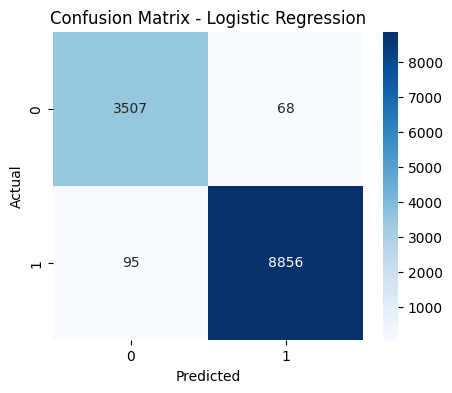

In [ ]:
# ====== تدريب Logistic Regression ======
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
logreg.fit(X_train_scaled, y_train)

# تنبؤات
y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]

# مقاييس
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, zero_division=0)
rec_lr = recall_score(y_test, y_pred_lr, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)

print("===== Logistic Regression Metrics =====")
print(f"Accuracy : {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall   : {rec_lr:.4f}")
print(f"F1-Score : {f1_lr:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# مصفوفة الارتباك
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


===== XGBoost Metrics =====
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-Score : 1.0000

Classification Report (XGBoost):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



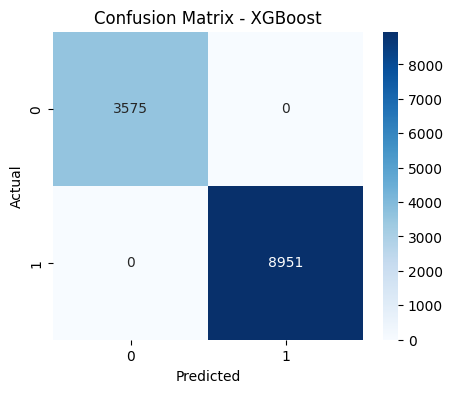

,Metric,LogisticRegression,XGBoost
0,Accuracy,0.986987,1.0
1,Precision,0.992380,1.0
2,Recall,0.989387,1.0
3,F1-Score,0.990881,1.0


🔎 الأهم لتطبيق إنذار الحريق هو Recall.
الأعلى Recall هنا: XGBoost


In [ ]:
# ====== تدريب XGBoost ======
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ تصحيح أسماء الأعمدة (حتى لا تحتوي رموز ممنوعة)
if hasattr(X_train, "columns"):
    X_train.columns = X_train.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)
    X_test.columns = X_test.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)
else:
    # إذا كانت بياناتك Numpy، نتركها كما هي
    X_train = np.array(X_train)
    X_test = np.array(X_test)

# ====== إنشاء وتدريب النموذج ======
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

# ====== التنبؤ ======
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# ====== مقاييس الأداء ======
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, zero_division=0)
rec_xgb = recall_score(y_test, y_pred_xgb, zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, zero_division=0)

print("===== XGBoost Metrics =====")
print(f"Accuracy : {acc_xgb:.4f}")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall   : {rec_xgb:.4f}")
print(f"F1-Score : {f1_xgb:.4f}")

print("\nClassification Report (XGBoost):\n")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

# ====== مصفوفة الارتباك ======
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ====== مقارنة سريعة بين النموذجين ======
comp = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "LogisticRegression": [acc_lr, prec_lr, rec_lr, f1_lr],
    "XGBoost": [acc_xgb, prec_xgb, rec_xgb, f1_xgb]
})
display(comp)

better = "XGBoost" if rec_xgb > rec_lr else "Logistic Regression"
print(f"🔎 الأهم لتطبيق إنذار الحريق هو Recall.\nالأعلى Recall هنا: {better}")
